In [1]:
#pip install psycopg2

In [2]:
#pip install pandas

In [3]:
#pip install dotenv

In [23]:
import pandas as pd
import psycopg2 as ps
from sqlalchemy import create_engine

import matplotlib.pyplot as plt

In [5]:
#load_dotenv()
def connect_to_database():
    
    # Define your database connection details
    db_config = {
        'user': 'postgres',
        'password': 'admin',
        'host': 'localhost',
        'port': '5432',
        'database': 'sql_course'
    }
    
    # Create a connection string
    connection_string = f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
    
    try:
        #conn = ps.connect(db_engine())
        # Create an engine
        engine = create_engine(connection_string)
        
        connection = engine.connect()
        print("Connection to the database was successful.")
        
        connection.close()
        
        return engine
        
    except Exception as e:
        #print(f"problems: {e}")
        # If connection fails, print the error
        print(f"Error connecting to the database: {e}")
        
        return None
   

In [6]:
# Connect to the database
engine = connect_to_database()

Connection to the database was successful.


#### 1. How many companies are there in total?

In [7]:
# Define your SQL query
query = '''
    SELECT 
        --To_CHAR(COUNT(company_id), 'FM999,999,999,999') AS "Total Companies"
        COUNT(company_id) AS "Total Companies"
    FROM company_dim  
'''

# Retrieve data from the database
results = pd.read_sql(query, engine)

# Extract the total number of companies
total_companies = results['Total Companies'][0]

# Show results
results

,Total Companies
0,140033


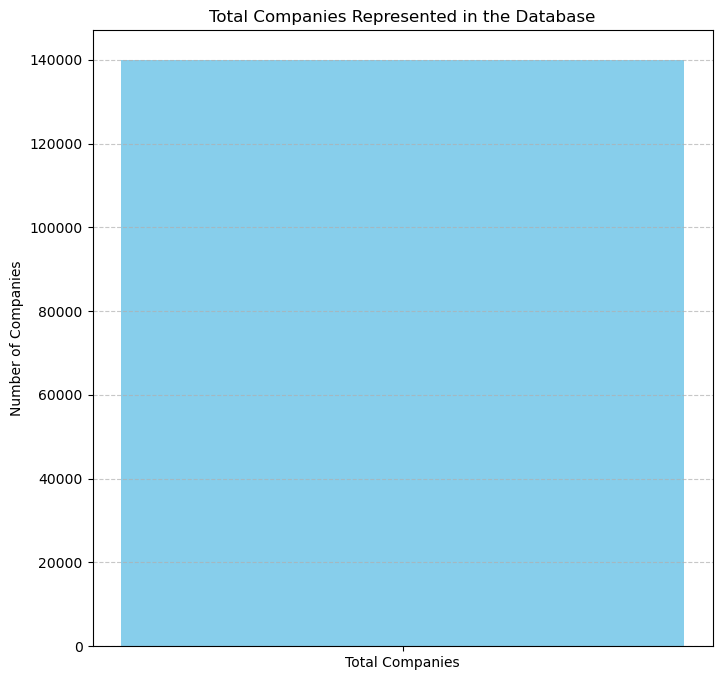

In [8]:
# Plotting the data
plt.figure(figsize=(8, 8))
plt.bar(['Total Companies'], [total_companies], color='skyblue')
plt.title('Total Companies Represented in the Database')
plt.ylabel('Number of Companies')
#plt.ylim(0, total_companies + 200)  # Adjust ylim if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 2. How many companies with less than 50 jobs compared with companies with more than 50 jobs?

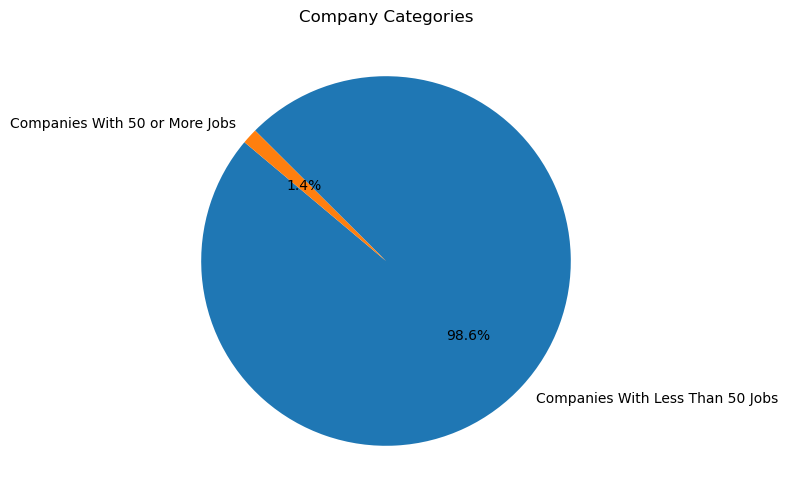

In [46]:
# Define your SQL query
query = '''
    WITH companies_with_jobs AS (
        SELECT 
            c.company_id, 
            COUNT(job_id) AS total_jobs 
        FROM 
            job_postings_fact jp 
        INNER JOIN 
            company_dim c ON jp.company_id = c.company_id
        GROUP BY c.company_id 
    )
    SELECT 
        CASE 
            WHEN total_jobs >= 50 THEN 'Companies With 50 or More Jobs'
            ELSE 'Companies With Less Than 50 Jobs'
        END AS company_category, 
        COUNT(*) AS total_jobs
    FROM 
        companies_with_jobs
    GROUP BY company_category 
    ORDER BY total_jobs DESC
'''

# Retrieve data from the database
results = pd.read_sql(query, engine)

# Extract labels and values from DataFrame
labels = results['company_category'].tolist()
values = results['total_jobs'].tolist()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Company Categories')
plt.show()

#### 3. Which companies have the highest number of job postings? Find to 10

In [10]:
# Define your SQL query
query = '''
    WITH companies AS (
        SELECT 
            c.name,
            TO_CHAR(COUNT(jp.company_id), 'FM999,999,999,999,999') AS total_job_counts,
            COUNT(jp.company_id) AS job_count
        FROM company_dim c 
        LEFT JOIN job_postings_fact jp 
            ON c.company_id = jp.company_id 
        GROUP BY c.name
    )
    SELECT 
        name AS "Company Name",
        total_job_counts AS "Total Job Posting" 
    FROM companies 
    ORDER BY job_count DESC
    LIMIT 10
'''

# Retrieve data from the database
results = pd.read_sql(query, engine)

# Show results
results.head(10)

,Company Name,Total Job Posting
0,Emprego,"6,661"
1,Booz Allen Hamilton,"2,890"
2,Dice,"2,825"
3,Harnham,"2,551"
4,Insight Global,"2,254"
5,Citi,"2,186"
6,Confidenziale,"2,039"
7,Capital One,"1,983"
8,Listopro,"1,973"
9,Robert Half,"1,863"


#### 4. Find out how many job titles are there and list them

In [11]:
# Define your SQL query
query = '''
    SELECT 
        DISTINCT(job_title_short) 
    FROM job_postings_fact 
    ORDER BY job_title_short ASC
'''

# Retrieve data from the database
results = pd.read_sql(query, engine)

# Count total rows
total_job_titles = len(results)

print(f"Total job titles: {total_job_titles}")

Total job titles: 10


In [12]:
# Show results
results

,job_title_short
0,Business Analyst
1,Cloud Engineer
2,Data Analyst
3,Data Engineer
4,Data Scientist
5,Machine Learning Engineer
6,Senior Data Analyst
7,Senior Data Engineer
8,Senior Data Scientist
9,Software Engineer


#### 5. How many job postings are there in total?

In [13]:
# Define your SQL query
query = '''
    SELECT 
        --To_CHAR(COUNT(job_id), 'FM999,999,999,999') AS "Total Job Posting" 
        COUNT(job_id) AS "Total Job Posting" 
    FROM job_postings_fact jp 
    INNER JOIN company_dim c 
        ON jp.company_id = c.company_id
'''

# Retrieve data from the database
results = pd.read_sql(query, engine)

# Extract the total number of job postings
total_job_postings = results['Total Job Posting'][0]

# Show results
results

,Total Job Posting
0,787686


#### 6. Find top 10 job titles with the highest job postings

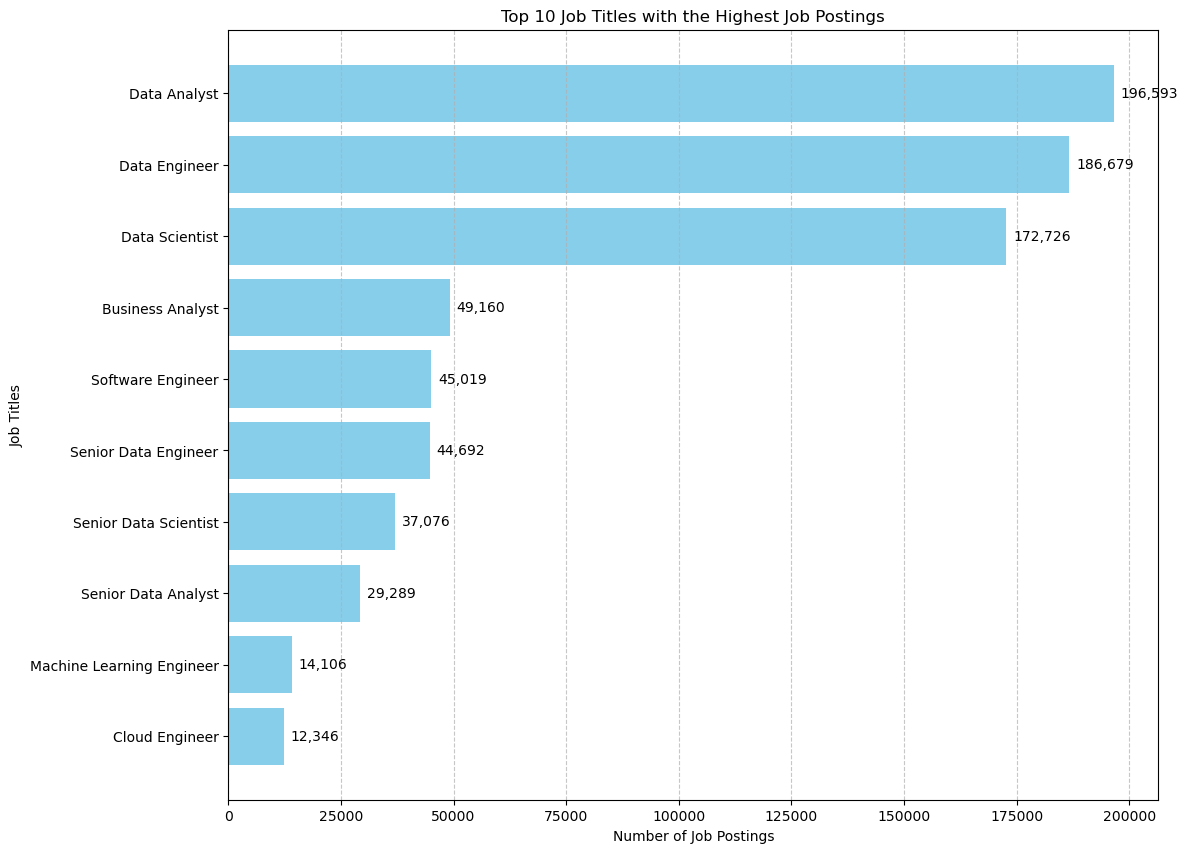

In [29]:
# Define your SQL query
query = '''
    WITH counted_data AS (
        SELECT 
            job_title_short AS Job_Title, 
            --TO_CHAR(COUNT(job_id), 'FM999,999,999,999,999') AS Total_No_Jobs,
            COUNT(job_id) AS Total_No_Jobs
            --COUNT(job_id) AS Job_Count 
        FROM job_postings_fact 
        GROUP BY job_title_short 
    )
    SELECT Job_Title, Total_No_Jobs
    FROM counted_data
    ORDER BY Total_No_Jobs DESC 
    LIMIT 10;
'''
# Retrieve data from the database
results = pd.read_sql(query, engine)

# Plotting the data as a horizontal bar chart
plt.figure(figsize=(12, 10))
bars = plt.barh(results['job_title'], results['total_no_jobs'], color='skyblue')
plt.xlabel('Number of Job Postings')
plt.ylabel('Job Titles')
plt.title('Top 10 Job Titles with the Highest Job Postings')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add the total number of jobs to each bar
for bar in bars:
    width = bar.get_width()
    plt.annotate(#'{}'.format(bar.get_width()),
                 f'{width:,.0f}',  # Format number with commas
                 xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 xytext=(5, 0),  # 5 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')
    
plt.show()

#### 7. Top 10 companies with highest average salary

In [16]:
# Define your SQL query
query = '''
    SELECT 
        jp.job_id AS "Job ID",
        c.name AS "Company Name",
        jp.job_title AS "Role",
        jp.job_location AS "Location",
        jp.job_schedule_type AS "Job Type",
        jp.salary_year_avg AS "Average Salary (in $)"
    FROM job_postings_fact jp 
    INNER JOIN company_dim c 
        ON jp.company_id = c.company_id 
    WHERE 
        salary_year_avg IS NOT NULL 
    ORDER BY 
        salary_year_avg DESC
    LIMIT 10;
'''

# Retrieve data from the database
results = pd.read_sql(query, engine)

# Show results
results.head(10)

,Job ID,Company Name,Role,Location,Job Type,Average Salary (in $)
0,177779,"East River Electric Power Cooperative, Inc.",Data Scientist,"Madison, SD",Full-time,960000.0
1,1008448,MSP Staffing LTD,Senior Data Scientist,"Pretoria, South Africa",Full-time,890000.0
2,226942,Mantys,Data Analyst,Anywhere,Full-time,650000.0
3,551617,ReServe,Geographic Information Systems Analyst - GIS A...,"New York, NY",Full-time,585000.0
4,40145,Selby Jennings,Staff Data Scientist/Quant Researcher,Anywhere,Full-time,550000.0
5,223758,Durlston Partners,Hybrid - Data Engineer - Up to $600k,"New York, NY",Full-time,525000.0
6,1714768,Selby Jennings,Staff Data Scientist - Business Analytics,Anywhere,Full-time,525000.0
7,327496,Glocomms,Senior Data Scientist,Anywhere,Full-time,475000.0
8,1495652,WhatsApp,VP Data Science & Research,"Menlo Park, CA",Full-time,463500.0
9,730717,Netflix,Data Engineer (L4) - Games,"New York, NY",Full-time,450000.0


#### 8. What are the most in-demand skills based on job postings?

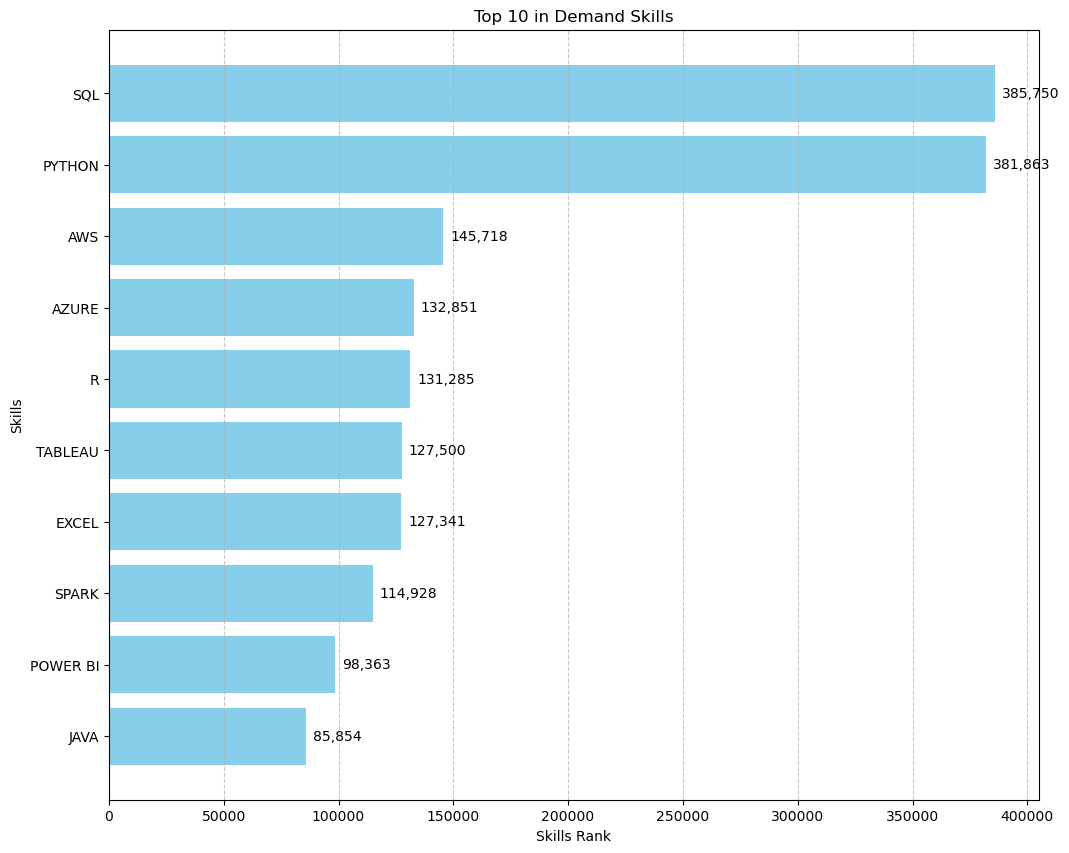

,Skill,Rank
0,SQL,385750
1,PYTHON,381863
2,AWS,145718
3,AZURE,132851
4,R,131285
5,TABLEAU,127500
6,EXCEL,127341
7,SPARK,114928
8,POWER BI,98363
9,JAVA,85854


In [30]:
# Define your SQL query
query = '''
    WITH top_paying_jobs AS (
        SELECT 
            jp.*,
            c.name AS company_name
        FROM job_postings_fact jp 
        INNER JOIN company_dim c 
            ON jp.company_id = c.company_id 
        --WHERE 
            --job_title_short = 'Data Analyst' AND 
            --EXTRACT(YEAR FROM job_posted_date) = 2023 
        ORDER BY jp.salary_year_avg DESC 
        --LIMIT 10
    )

    SELECT 
        UPPER(skills) AS "Skill", 
        COUNT(skills) AS "Rank"
    FROM 
        top_paying_jobs tpj
    INNER JOIN 
        skills_job_dim sj ON tpj.job_id = sj.job_id
    INNER JOIN 
        skills_dim sd ON sj.skill_id = sd.skill_id
    GROUP BY skills
    ORDER BY COUNT(skills) DESC 
    LIMIT 10
'''

# Retrieve data from the database
results = pd.read_sql(query, engine)

# Plotting the data as a horizontal bar chart
plt.figure(figsize=(12, 10))
bars = plt.barh(results['Skill'], results['Rank'], color='skyblue')
plt.xlabel('Skills Count')
plt.ylabel('Skills')
plt.title('Top 10 in Demand Skills')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add the total number of jobs to each bar
for bar in bars:
    width = bar.get_width()
    plt.annotate(#'{}'.format(bar.get_width()),
                 f'{width:,.0f}',  # Format number with commas
                 xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 xytext=(5, 0),  # 5 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')
    
plt.show()

# Show results
results.head(10)

#### 9. Are there specific skills that are more commonly required for certain types of jobs? List top 5

In [18]:

query = '''
    SELECT
        s.skills,
        s.type,
        COUNT(s.skills) AS skill_count
    FROM
        skills_dim s
    INNER JOIN
        skills_job_dim sj ON sj.skill_id = s.skill_id
    INNER JOIN
        job_postings_fact jp ON sj.job_id = jp.job_id
    GROUP BY
        s.skills, s.type
    ORDER BY
        s.type, skill_count DESC
    LIMIT 5;
'''

# Retrieve data from the database
results = pd.read_sql(query, engine)

# Show results
results

,skills,type,skill_count
0,tableau,analyst_tools,127500
1,excel,analyst_tools,127341
2,power bi,analyst_tools,98363
3,sas,analyst_tools,41826
4,word,analyst_tools,30645
